In [1]:
# Initialization
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

raw_tr = pd.read_csv("data/train.csv")
raw_tr = raw_tr.replace(to_replace=-999, value=np.nan)

raw_te = pd.read_csv("data/test.csv")
raw_te = raw_te.replace(to_replace=-999, value=np.nan)

os.chdir("utils")

In [2]:
# Explore NaNs
nans = raw_tr.isnull() 
nan_cols = nans.sum(axis=0) / raw_tr.shape[0]
nan_rows = nans.sum(axis=1)

with pd.option_context('display.float_format','{:.4%}'.format):
    print("NaN column summary:\n{}\n".format(nan_cols[nan_cols > 0]))
print("NaN row summary:\n{}".format(nan_rows[nan_rows > 0]))

print("\nShapes")
print("\traw: {}".format(raw_tr.shape))
print("\tdrop rows: {}".format(raw_tr.dropna(axis=0).shape))
print("\tdrop cols: {}".format(raw_tr.dropna(axis=1).shape))

NaN column summary:
DER_mass_MMC             15.2456%
DER_deltaeta_jet_jet     70.9828%
DER_mass_jet_jet         70.9828%
DER_prodeta_jet_jet      70.9828%
DER_lep_eta_centrality   70.9828%
PRI_jet_leading_pt       39.9652%
PRI_jet_leading_eta      39.9652%
PRI_jet_leading_phi      39.9652%
PRI_jet_subleading_pt    70.9828%
PRI_jet_subleading_eta   70.9828%
PRI_jet_subleading_phi   70.9828%
dtype: float64

NaN row summary:
1          7
2          8
3         10
4         10
7          7
          ..
249995    11
249996    11
249997     7
249998    10
249999    11
Length: 181886, dtype: int64

Shapes
	raw: (250000, 32)
	drop rows: (68114, 32)
	drop cols: (250000, 21)


In [3]:
################################################################################
# Prepare data and labels
################################################################################

# Drop rows with NaNs
#data = raw.dropna(axis=0)

# Drop columns with NaNs
#data = raw.dropna(axis=1)

# Replace NaNs with mean of the column
#means = raw_tr.means()
#train = raw_tr.fillna(means)
#test = raw_te.fillna(means)

# Signal = 1, Background = 0
train = raw_tr.replace({'s':1,'b':0})
test = raw_te.replace({'s':1,'b':0})

# Split data and labels
X = train.drop(columns=['Id','Prediction'])
y = train['Prediction']

# Standarize data
from utils.helpers import standardize
X, mean, std = standardize(X)

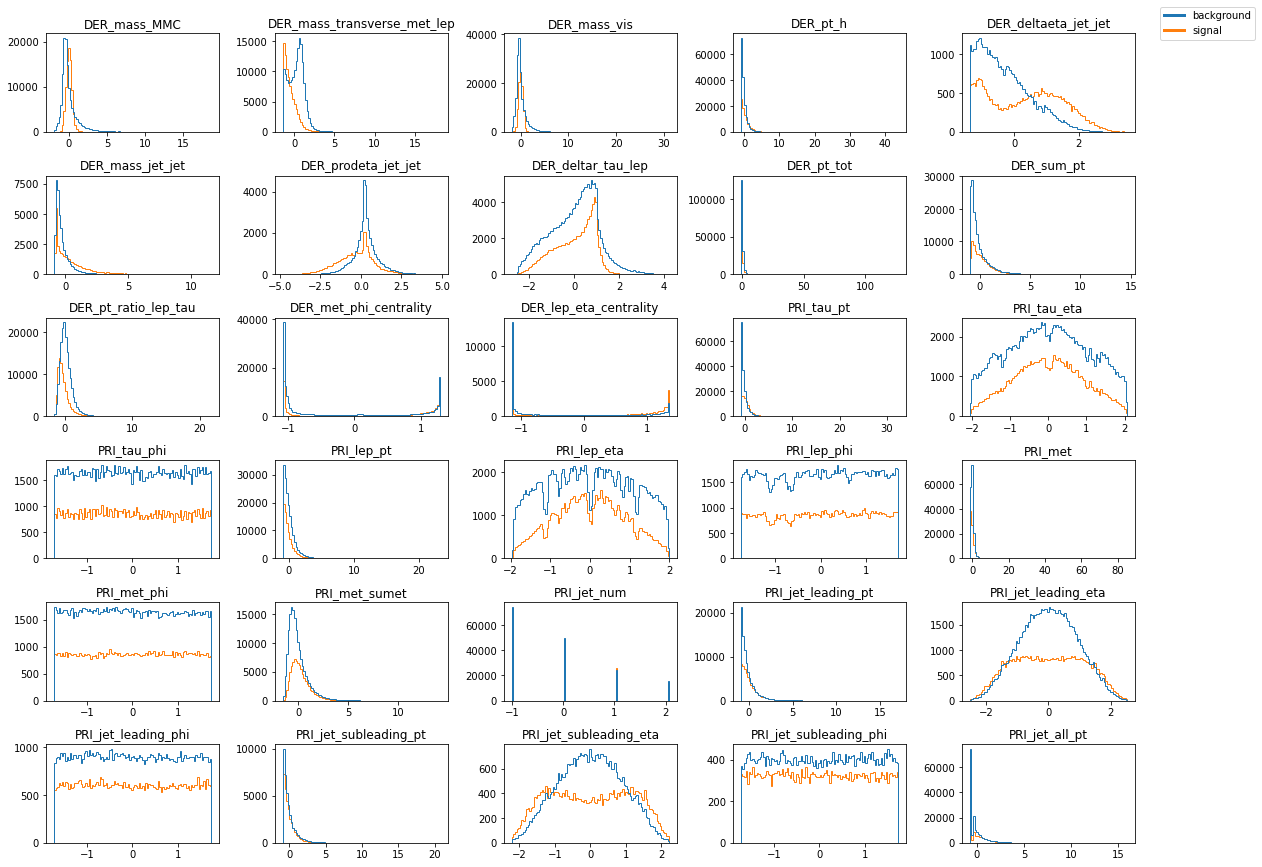

In [4]:
from matplotlib.lines import Line2D
def plot_histogram(y, X):
    mask = (y == 0)
    labels = ("background","signal")
    n = X.shape[1]
    
    nrows = (n+4)//5
    ncols = 5
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(16,12))
    
    for k, name in enumerate(X):
        row = k // ncols
        col = k % ncols
        axs[row, col].hist([X[name][mask], X[name][~mask]], 
                 label=labels, 
                 bins=100, 
                 histtype='step');
        axs[row, col].set_title(name)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:2]
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
    fig.legend(lines, labels, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    fig.tight_layout()

plot_histogram(y, X)

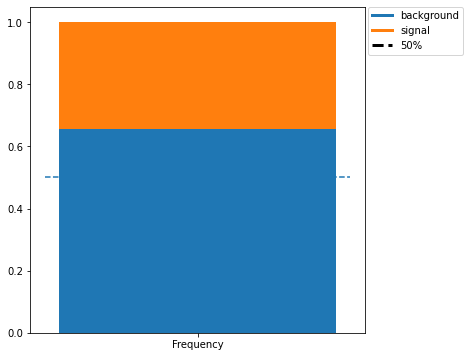

In [5]:
def plot_bar_counts(y, X):
    width = 0.5
    idx = (1,)
    labels = ("background","signal","50%")
    
    vals, counts = np.unique(y, return_counts=True)
    assert (len(vals) == 2)
    
    b = counts[vals == 0] / y.shape[0]
    s = counts[vals == 1] / y.shape[0]

    plt.figure(figsize=(6,6))
    plt.bar(idx, b, width)
    plt.bar(idx, s, width, bottom=b)
    plt.xticks(idx, ('Frequency',))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:2]
    lines = [Line2D([0], [0], color=c, linewidth=3, linestyle='-') for c in colors]
    
    left, right = plt.xlim()
    plt.hlines(0.5, left, right, linestyle='--')
    colors.append('black')
    lines.append(Line2D([0], [0], color='black', linewidth=3, linestyle='--'))
    
    plt.legend(lines, labels, bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)

plot_bar_counts(y, X)

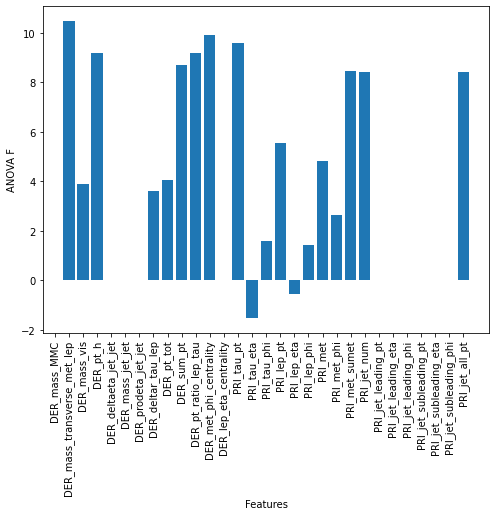

In [6]:
from scipy import stats

# ANOVA:
#  - https://dzone.com/articles/correlation-between-categorical-and-continuous-var-1

corr = np.empty(train.shape[1]-2)
cols = [col for col in train.drop(columns=['Id','Prediction'])]

for j, col in enumerate(cols):
    F, p = stats.f_oneway(train[train['Prediction']==0][col],
                          train[train['Prediction']==1][col])
    corr[j] = F

idx = np.arange(corr.shape[0])
plt.figure(figsize=(8,6))
plt.bar(idx, np.log(corr))
plt.xticks(idx, cols, rotation=90)
plt.xlabel('Features')
plt.ylabel('ANOVA F')
plt.show()

-----------------------------------------------
# Prepare Features
-----------------------------------------------

In [22]:
from itertools import combinations
import math

def build_poly(x, degree):
    """polynomial basis functions for each column of x, for j=1 up to j=degree, and single constant term."""
    if (degree < 0): raise ValueError("degree must be positive")
    
    phi = np.empty((x.shape[0], x.shape[1]*degree+1))
    
    # Constant term
    phi[:,-1] = 1
    
    # Higher order terms
    for j in range(x.shape[1]):
        phi[:,j*degree] = x[:,j]
        for d in range(1,degree):
            col = j*degree+d
            phi[:,col] = phi[:,col-1] * x[:,j]
    
    return phi

def standardize_numpy(x):
    """Standardize the original data set. Works on numpy arrays."""
    mean_x = x.mean(axis=0, keepdims=True)
    x = x - mean_x
    std_x = x.std(axis=0, keepdims=True)
    x = x / std_x
    return x, mean_x, std_x

def prepare_feautres(tx_nan, degree, mean=None): 
    # Get column means, if necessary
    if mean is None:
        mean = np.nanmean(tx_nan,axis=0)
    
    # Replace NaNs
    tx_val = np.where(np.isnan(tx_nan), mean, tx_nan)
    
    # Polynomial features
    tx = build_poly(tx_val, degree)
    const_col = tx.shape[1]-1
    
    # Degree 2 interaction terms
    int_idx = np.arange(tx_val.shape[1])
    int_cols = np.empty((tx_val.shape[0], math.comb(tx_val.shape[1],2)))
    for j, pair in enumerate(combinations(int_idx,2)): 
        int_cols[:,j] = tx_val[:,pair[0]]*tx_val[:,pair[1]]
    
    # Add NaN indicator columns
    nan_cols = np.flatnonzero(np.any(np.isnan(tx_nan), axis=0))

    ind_cols = np.empty((tx_nan.shape[0], nan_cols.shape[0]))
    ind_cols = np.where(np.isnan(tx_nan[:,nan_cols]), 1, 0)

    tx = np.c_[tx, int_cols, ind_cols]
    
    # Standardize
    tx, _, _ = standardize_numpy(tx)
    tx[:,const_col] = 1.0
    
    return tx, mean, nan_cols

--------------------------------------------
# Hyper-Parameter Selection
--------------------------------------------

In [15]:
def build_k_indices(y, k_fold, seed):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def prepare_split_data(y, tx, degree, k_fold, seed):
    """
    Split the dataset based on k-fold cross validation and prepare features. 
    Returns the k splits.
    """
    k_indices = build_k_indices(y, k_fold, seed)
    
    tx_trs = []
    y_trs = []
    tx_tes = []
    y_tes = []
    
    for k in range(k_fold):
        # get k-th subgroup in test, others in train
        mask = np.full((y.shape[0]), False, dtype=bool)
        mask[k_indices[k]] = True
    
        y_te = y[mask]
        tx_te = tx[mask]
    
        mask = ~mask
        y_tr = y[mask]
        tx_tr = tx[mask]
        
        # Replace NaNs and standarize
        tx_tr, mean, _ = prepare_feautres(tx_tr, degree)
        tx_te, _, _ = prepare_feautres(tx_te, degree, mean)
        
        tx_trs.append(tx_tr)
        y_trs.append(y_tr)
        tx_tes.append(tx_te)
        y_tes.append(y_te)
    
    return y_trs, tx_trs, y_tes, tx_tes

In [23]:
from utils.implementations import reg_logistic_regression
from utils.costs import reg_logistic_error
from utils.helpers import sigmoid
from utils.cross_validation import *

def cross_validation(y_tr, tx_tr, y_te, tx_te, lambda_, gamma, reg, max_iters): 
    # ridge regression
    w, loss = reg_logistic_regression(
                y=y_tr,
                tx=tx_tr,
                initial_w=np.zeros((tx_tr.shape[1])),
                max_iters=max_iters,
                lambda_=lambda_,
                gamma=gamma,
                batch_size = 1, # Stochastic Gradient Descent
                reg=reg)
    
    # calculate the loss for train and test data    
    loss_tr = reg_logistic_error(y_tr, tx_tr, w, lambda_, reg)
    loss_te = reg_logistic_error(y_te, tx_te, w, lambda_, reg)
    
    p = np.rint(sigmoid(tx_te @ w))
    f1 = f1_score(y_te, p)
    acc = accuracy(y_te, p)
    
    return loss_tr, loss_te, f1, acc


def model_selection(y, tx, k_fold, degree, seeds, gammas, lambdas, max_iters, reg, verbose=2):
    
    max_loss = np.finfo(float).min
    max_acc = np.finfo(float).min
    
    all_loss = np.zeros((len(seeds),len(gammas),len(lambdas)))
    all_f1 = np.zeros((len(seeds),len(gammas),len(lambdas)))
    all_acc = np.zeros((len(seeds),len(gammas),len(lambdas)))
    
    print(f'Trainig on {int((1-1/k_fold)*y.shape[0])} samples')
    for s, seed in enumerate(seeds):
        print(f'Seed {seed}')
        y_trs, tx_trs, y_tes, tx_tes = prepare_split_data(y, tx, degree, k_fold, seed)
        for l, lambda_ in enumerate(lambdas):
            print(f'\tlambda {lambda_:.4e}')
            for g, gamma in enumerate(gammas):
                # Cross validation
                loss_tr = 0.0
                loss_te = 0.0
                f1_te = 0.0
                acc_te = 0.0
                for k in range(k_fold):
                    tr, te, f1, acc = cross_validation(y_trs[k], tx_trs[k], y_tes[k], tx_tes[k], lambda_, gamma, reg, max_iters)
                    loss_tr += tr
                    loss_te += te
                    f1_te += f1
                    acc_te += acc
                    
                    if verbose > 1:
                        print(f'\t\t\tTR={tr:.4e} | TE={te:.4e} | F1:{f1:.4f} | ACC:{acc:.4f}')
                        
                    if ~np.all(np.isfinite((tr, te, f1, acc))): break
                
                loss_tr /= k+1
                loss_te /= k+1
                f1_te /= k+1
                acc_te /= k+1
                all_loss[s, g, l] = loss_te
                all_f1[s, g, l] = f1_te
                all_acc[s, g, l] = acc_te
            
                if verbose > 0:
                    print(f'\t\tgamma {gamma:.4e}: TR={loss_tr:.4e} | TE={loss_te:.4e} | F1:{f1_te:.4f} | ACC:{acc_te:.4f}')
                
                if max_acc < acc_te:
                    min_loss = loss_te
                    min_lambda = lambda_
                    min_gamma = gamma
                    max_f1 = f1_te
                    max_acc = acc_te
    
    print(f'\nMINIMUMS:')
    print(f'\tlambda={min_lambda:.4e}')
    print(f'\tgamma={min_gamma:.4e}')
    print(f'\tTest loss={min_loss:.4e}')
    print(f'\tAccuracy={max_acc:.4f}')
    
    return max_acc, min_lambda, min_gamma, all_loss, all_f1, all_acc

In [24]:
gammas = np.logspace(-2, 0, 10)   # Learning rate
lambdas = np.logspace(-2, 1, 10)  # Regularization term
#seeds = (42, 1729, 12345)
seeds = (42,)
max_iters = 100
reg = 2 # L2 regularization
k_fold = 4
verbose = 1

degree = 2

tx = np.asarray(train.drop(columns=['Id','Prediction']))
y = np.asarray(train['Prediction'])
max_acc, min_lambda, min_gamma, all_loss, all_f1, all_acc = model_selection(y, tx, k_fold, degree, seeds, gammas, lambdas, max_iters, reg, verbose)

Trainig on 187500 samples
Seed 42


<ipython-input-22-4795cd64070c>:27: RuntimeWarning: invalid value encountered in true_divide
  x = x / std_x


	lambda 1.0000e-02
		gamma 1.0000e-02: TR=9.0007e-01 | TE=9.0024e-01 | F1:0.6459 | ACC:0.7330
		gamma 1.6681e-02: TR=9.5690e-01 | TE=9.5701e-01 | F1:0.6547 | ACC:0.7451
		gamma 2.7826e-02: TR=1.0229e+00 | TE=1.0229e+00 | F1:0.6607 | ACC:0.7581
		gamma 4.6416e-02: TR=1.1051e+00 | TE=1.1049e+00 | F1:0.6621 | ACC:0.7686
		gamma 7.7426e-02: TR=1.1995e+00 | TE=1.1991e+00 | F1:0.6612 | ACC:0.7763
		gamma 1.2915e-01: TR=1.2898e+00 | TE=1.2890e+00 | F1:0.6615 | ACC:0.7814


/home/dna/epflml-projects/Project_1/utils/costs.py:67: RuntimeWarning: divide by zero encountered in log
  loss = (- 1 / tx.shape[0]) * np.sum(y * np.log(a) + (1 - y) * (np.log(1 - a)))
/home/dna/epflml-projects/Project_1/utils/costs.py:67: RuntimeWarning: divide by zero encountered in log
  loss = (- 1 / tx.shape[0]) * np.sum(y * np.log(a) + (1 - y) * (np.log(1 - a)))


		gamma 2.1544e-01: TR=inf | TE=1.3587e+00 | F1:0.6481 | ACC:0.7711


/home/dna/epflml-projects/Project_1/utils/costs.py:67: RuntimeWarning: invalid value encountered in multiply
  loss = (- 1 / tx.shape[0]) * np.sum(y * np.log(a) + (1 - y) * (np.log(1 - a)))
/home/dna/epflml-projects/Project_1/utils/costs.py:67: RuntimeWarning: invalid value encountered in multiply
  loss = (- 1 / tx.shape[0]) * np.sum(y * np.log(a) + (1 - y) * (np.log(1 - a)))


		gamma 3.5938e-01: TR=nan | TE=nan | F1:0.5943 | ACC:0.7102
		gamma 5.9948e-01: TR=nan | TE=nan | F1:0.5628 | ACC:0.6683
		gamma 1.0000e+00: TR=nan | TE=nan | F1:0.5928 | ACC:0.7461
	lambda 2.1544e-02
		gamma 1.0000e-02: TR=8.9801e-01 | TE=8.9818e-01 | F1:0.6457 | ACC:0.7328
		gamma 1.6681e-02: TR=9.5341e-01 | TE=9.5352e-01 | F1:0.6543 | ACC:0.7446
		gamma 2.7826e-02: TR=1.0167e+00 | TE=1.0166e+00 | F1:0.6602 | ACC:0.7572
		gamma 4.6416e-02: TR=1.0925e+00 | TE=1.0924e+00 | F1:0.6618 | ACC:0.7674
		gamma 7.7426e-02: TR=1.1738e+00 | TE=1.1734e+00 | F1:0.6619 | ACC:0.7750
		gamma 1.2915e-01: TR=1.2424e+00 | TE=1.2417e+00 | F1:0.6627 | ACC:0.7797
		gamma 2.1544e-01: TR=1.2686e+00 | TE=1.2668e+00 | F1:0.6489 | ACC:0.7689
		gamma 3.5938e-01: TR=nan | TE=nan | F1:0.5813 | ACC:0.6896
		gamma 5.9948e-01: TR=nan | TE=nan | F1:0.5738 | ACC:0.6660
		gamma 1.0000e+00: TR=nan | TE=inf | F1:0.6352 | ACC:0.7689
	lambda 4.6416e-02
		gamma 1.0000e-02: TR=8.9363e-01 | TE=8.9380e-01 | F1:0.6453 | ACC:0.7

/home/dna/epflml-projects/Project_1/utils/helpers.py:108: RuntimeWarning: overflow encountered in exp
  a = 1 / (1 + np.exp(-x))
/home/dna/epflml-projects/Project_1/utils/helpers.py:108: RuntimeWarning: overflow encountered in exp
  a = 1 / (1 + np.exp(-x))


		gamma 1.0000e+00: TR=nan | TE=nan | F1:0.3423 | ACC:0.3633
	lambda 2.1544e+00
		gamma 1.0000e-02: TR=7.1653e-01 | TE=7.1660e-01 | F1:0.6087 | ACC:0.7047
		gamma 1.6681e-02: TR=7.1678e-01 | TE=7.1685e-01 | F1:0.6088 | ACC:0.7048
		gamma 2.7826e-02: TR=7.1679e-01 | TE=7.1686e-01 | F1:0.6088 | ACC:0.7048
		gamma 4.6416e-02: TR=7.1679e-01 | TE=7.1686e-01 | F1:0.6088 | ACC:0.7048
		gamma 7.7426e-02: TR=7.1679e-01 | TE=7.1686e-01 | F1:0.6088 | ACC:0.7048
		gamma 1.2915e-01: TR=6.9232e-01 | TE=6.9214e-01 | F1:0.4790 | ACC:0.4945
		gamma 2.1544e-01: TR=nan | TE=nan | F1:0.3633 | ACC:0.3851
		gamma 3.5938e-01: TR=nan | TE=nan | F1:0.3485 | ACC:0.3695
		gamma 5.9948e-01: TR=nan | TE=nan | F1:0.3206 | ACC:0.3462
		gamma 1.0000e+00: TR=nan | TE=nan | F1:0.3034 | ACC:0.3318
	lambda 4.6416e+00
		gamma 1.0000e-02: TR=6.6265e-01 | TE=6.6269e-01 | F1:0.5899 | ACC:0.6930
		gamma 1.6681e-02: TR=6.6265e-01 | TE=6.6269e-01 | F1:0.5899 | ACC:0.6930
		gamma 2.7826e-02: TR=6.6265e-01 | TE=6.6269e-01 | F1:0.

In [25]:
# Save expensive computation
#%store all_loss all_f1 all_acc min_gamma min_lambda
#%store -r all_loss all_f1 all_acc min_gamma min_lambda

#MINIMUMS:
#	lambda=1.0000e-02
#	gamma=5.9948e-01
#	Test loss=1.2879e+00
#	Accuracy=0.7725

Stored 'all_loss' (ndarray)
Stored 'all_f1' (ndarray)
Stored 'all_acc' (ndarray)
Stored 'min_gamma' (float64)
Stored 'min_lambda' (float64)


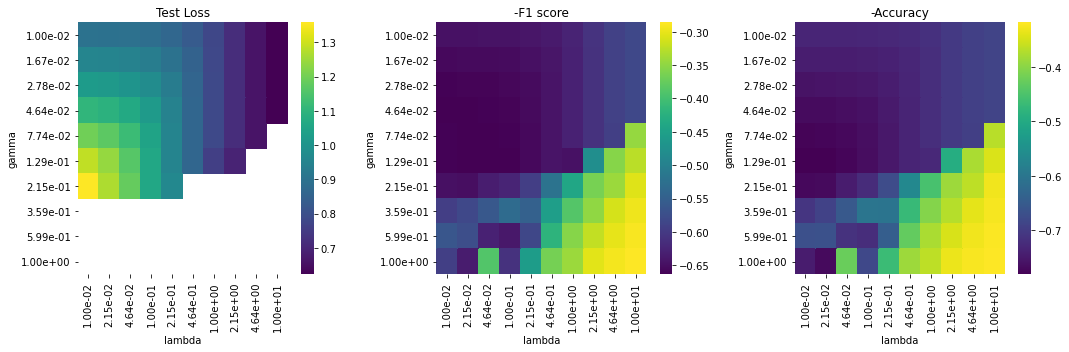

In [26]:
import seaborn as sns

def plot_heatmap(ax, vals, title):
    mask = ~np.isfinite(vals)
    sns.heatmap(vals,
        mask=mask, 
        xticklabels=[f'{x:.2e}' for x in lambdas], 
        yticklabels=[f'{x:.2e}' for x in gammas],
        ax=ax,
        cmap='viridis')
    ax.set_xlabel('lambda')
    ax.set_ylabel('gamma')
    ax.set_title(title)

fig, axs = plt.subplots(1, 3, figsize=(15,5))
plot_heatmap(axs[0], all_loss.mean(axis=0), 'Test Loss')
plot_heatmap(axs[1], -all_f1.mean(axis=0), '-F1 score')
plot_heatmap(axs[2], -all_acc.mean(axis=0), '-Accuracy')

fig.tight_layout()

----------------------------------------------------------------
# Train
----------------------------------------------------------------
Train model on all data with optimal hyper-parameters.

In [27]:
from utils.costs import logistic_error
from utils.helpers import sigmoid

# Prepare training and test data
tx_tr = np.asarray(train.drop(columns=['Id','Prediction']))
y_tr = np.asarray(train['Prediction'])

tx_te = np.asarray(test.drop(columns=['Id','Prediction']))

tx_tr, mean, nan_cols = prepare_feautres(tx_tr, degree)
tx_te, _, _ = prepare_feautres(tx_te, degree, mean)

# Train model
w, loss = reg_logistic_regression(
                y=y_tr,
                tx=tx_tr,
                initial_w=np.zeros((tx_tr.shape[1])),
                lambda_=min_lambda,
                gamma=min_gamma,
                max_iters=max_iters,
                batch_size=1, # Stochastic Gradient Descent
                reg=reg)

# Report results
loss_tr = logistic_error(y_tr, tx_tr, w)
y_pred = np.rint(sigmoid(tx_tr @ w))
f1 = f1_score(y_tr, y_pred)
acc = accuracy(y_tr, y_pred)

print('RESULTS:')
print(f'\tlambda:   {min_lambda:.4e}')
print(f'\tgamma:    {min_gamma:.4e}')
print(f'\tLoss:     {loss_tr:.4e}')
print(f'\tF1 score: {f1:.4f}')
print(f'\tAccuracy: {acc:.4f}')

<ipython-input-22-4795cd64070c>:27: RuntimeWarning: invalid value encountered in true_divide
  x = x / std_x


RESULTS:
	lambda:   1.0000e-02
	gamma:    1.2915e-01
	Loss:     1.2775e+00
	F1 score: 0.6631
	Accuracy: 0.7822


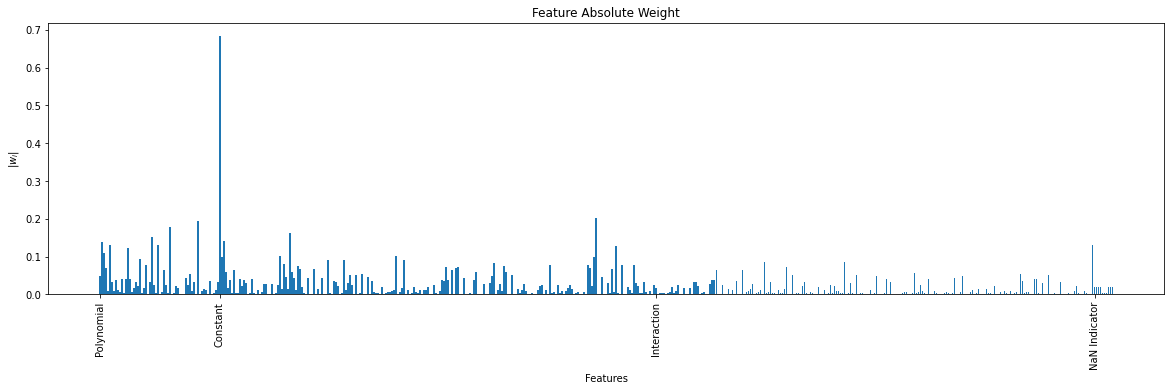

In [67]:
def feature_labels_full(df, nan_cols, degree):
    col_names = [col for col in df.drop(columns=['Id','Prediction'])]
    
    poly_labels = []
    for name in col_names:
        for d in range(degree):
            poly_labels.append(f'{name}^{d}')
    
    int_labels = []
    for pair in combinations(col_names,2):
        int_labels.append(f'{pair[0]} x {pair[1]}')
    
    nan_labels = [f'IND:{col}' for col in train.drop(columns=['Id','Prediction']).iloc[:,nan_cols]]
    
    labels = poly_labels + ['constant'] + int_labels + nan_labels
    
    idx = np.arange(len(labels)) 
    idx[:len(col_names)+1] *= degree
    idx[len(col_names)+1:] += idx[len(col_names)] - idx[len(col_names)+1] + 1
    
    return idx, labels

def feature_labels_regions(df, w, nan_cols, degree):  
    labels = ['Polynomial','Constant','Interaction','NaN Indicator']
    
    idx = np.zeros(len(labels))
    idx[1] = (df.shape[1]-2)*degree
    idx[3] = w.shape[0] - nan_cols.shape[0] + 1
    idx[2] = (idx[1] + idx[3])//2
    
    return idx, labels
    


# Plot feature weights
fig = plt.figure(figsize=(20,5))
plt.bar(np.arange(w.shape[0]), abs(w))

idx, labels = feature_labels_regions(train, w, nan_cols, degree)
plt.xticks(idx, labels, rotation=90)
plt.xlabel('Features')
plt.ylabel('$|w_i|$')
plt.title('Feature Absolute Weight');

In [64]:
idx, labels = feature_labels_full(train, nan_cols, degree)
perm = np.argsort(-abs(w))
for i in range(w.shape[0]):
    print(f'{labels[perm[i]]:55s} = {abs(w[perm[i]]):.4e}')

constant                                                = 6.8503e-01
DER_deltar_tau_lep x PRI_tau_pt                         = 2.0217e-01
PRI_jet_leading_eta^1                                   = 1.9447e-01
PRI_lep_eta^1                                           = 1.7837e-01
DER_mass_transverse_met_lep x DER_deltar_tau_lep        = 1.6149e-01
PRI_tau_pt^0                                            = 1.5114e-01
DER_mass_MMC x DER_mass_vis                             = 1.4097e-01
DER_mass_MMC^1                                          = 1.3931e-01
DER_mass_vis^1                                          = 1.3204e-01
IND:DER_mass_MMC                                        = 1.3053e-01
PRI_tau_eta^1                                           = 1.2971e-01
DER_deltar_tau_lep x PRI_jet_leading_pt                 = 1.2713e-01
DER_deltar_tau_lep^0                                    = 1.2319e-01
DER_mass_transverse_met_lep^0                           = 1.0974e-01
DER_mass_transverse_met_lep x DER_

-------------------------------------
# Generate Submission
-------------------------------------

In [ ]:
from utils.helpers import create_csv_submission
import importlib

ids = test['Id']
y_pred = np.rint(sigmoid(tx_te @ w))
y_pred[y_pred == 0] = -1
y_pred[y_pred == 1] = 1

create_csv_submission(ids, y_pred, '../submission.csv')

### NOTES
 - It seems that adding the missing value indicators makes the method more "consitent with expectation". 
That is, the test loss and accuracy now follow similar patterns (both go up/down together). Without them, the highest accuracy tended to be where the test loss "blew up" (inf or nan).

- While the local CV did not make much difference between imputing NaNs with the median or mean, i=on AIcrowd the prediction using the mean was better (0.744 -> 0.761)

- Originally, I had `initial_w=np.ones()` to initialize the SGD. By changing it to `initial_w=np.zeros()`, the results were much better for similar combinations of hyper-parameters. Specifically, the accuracy went up, and there were less instances of the method "blowing up" to infs or nans. This makes sense because with regularization the minimum loss will be close to the origin, and starting at a point close to the solution improves both stability and the final result (given gamma not too large).